<a href="https://colab.research.google.com/github/DeepPatel21313/CarPricePrediction/blob/main/MalariaDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Data Preparation
# Data Loading


In [133]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [134]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [135]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

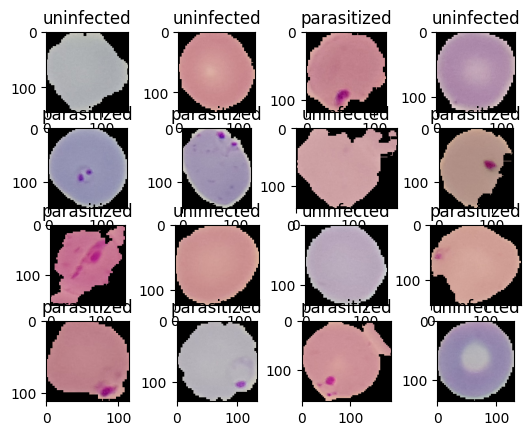

In [136]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

# Data Preprocessing

In [137]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [138]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [139]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [140]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [141]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [142]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [143]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [144]:
lenet_model = tf.keras.Sequential([InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Flatten(),

                             Dense(100, activation='relu'),
                             BatchNormalization(),
                             Dense(10, activation='relu'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid'),
                             ])
lenet_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_17 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

In [145]:
# y_true = [0, 1, 0, 0]
# y_pred = [0.6, 0.00051, 0.94, 0.00001]
# bce = tf.keras.losses.BinaryCrossentropy()
# bce(y_true,y_pred)

In [146]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy'
              )

In [147]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 7, verbose=1)

Epoch 1/7
689/689 [==============================] - 51s 69ms/step - loss: 0.3048 - accuracy: 0.8759 - val_loss: 0.2309 - val_accuracy: 0.9278
Epoch 2/7
689/689 [==============================] - 47s 68ms/step - loss: 0.1933 - accuracy: 0.9355 - val_loss: 0.1914 - val_accuracy: 0.9390
Epoch 3/7
689/689 [==============================] - 46s 66ms/step - loss: 0.1735 - accuracy: 0.9435 - val_loss: 3.0696 - val_accuracy: 0.6508
Epoch 4/7
689/689 [==============================] - 48s 69ms/step - loss: 0.1601 - accuracy: 0.9477 - val_loss: 0.5800 - val_accuracy: 0.8926
Epoch 5/7
689/689 [==============================] - 47s 69ms/step - loss: 0.1475 - accuracy: 0.9511 - val_loss: 0.2245 - val_accuracy: 0.9347
Epoch 6/7
689/689 [==============================] - 53s 77ms/step - loss: 0.1257 - accuracy: 0.9566 - val_loss: 0.1793 - val_accuracy: 0.9448
Epoch 7/7
689/689 [==============================] - 45s 66ms/step - loss: 0.1101 - accuracy: 0.9609 - val_loss: 0.1931 - val_accuracy: 0.9426

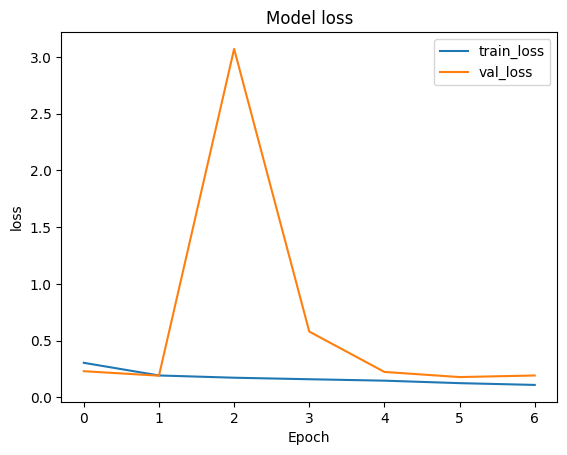

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

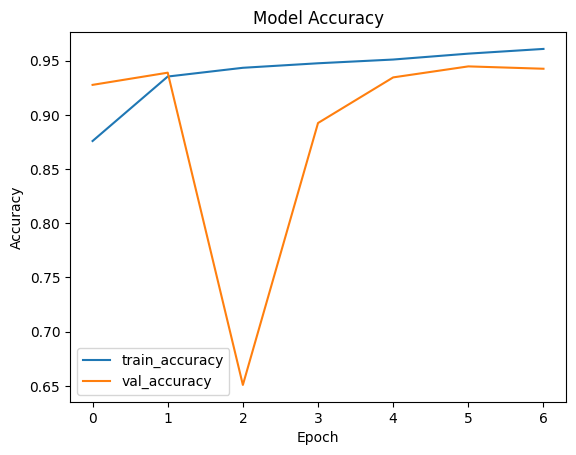

In [149]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [150]:
test_dataset = test_dataset.batch(1)

In [151]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [152]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.2270 - accuracy: 0.9322


[0.22700081765651703, 0.9321726560592651]

In [154]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [155]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 19ms/step


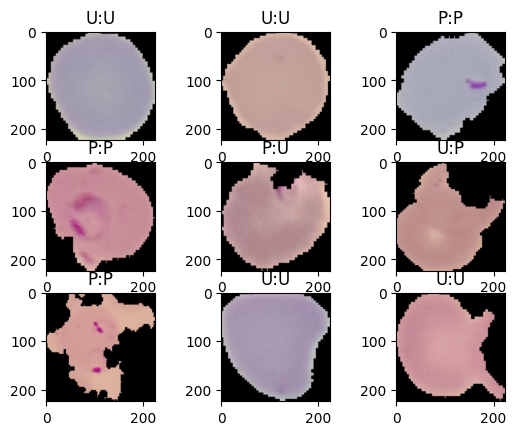

In [156]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(lenet_model.predict(image)[0][0])))

# Saving and loading in colab

In [172]:
# from google.colab import drive
# from keras.models import load_model

In [168]:
# drive.mount('/drive', force_remount=True)

Mounted at /drive


In [171]:
# lenet_model.save('/drive/MyDrive/lenet_model.h5')

In [173]:
# loaded_model = load_model('/drive/MyDrive/lenet_model.h5')
# loaded_model.evaluate(test_dataset)

2757/2757 [==============================] - 24s 4ms/step - loss: 0.2263 - accuracy: 0.9329


[0.22625872492790222, 0.9328981041908264]